In [4]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [5]:
ab = '../../lr_bulk/talon/human_talon_abundance.tsv'
filt_ab = '../../lr_bulk/cerberus/cerberus_filtered_abundance.tsv'
read_annot = '../../lr_bulk/talon/human_talon_read_annot.tsv'
t_metadata = '../../refs/cerberus/v40_transcript_metadata.tsv'
swan_file = '../../lr_bulk/cerberus/swan/swan_meta.p'
bam_summary = '../../lr_bulk/bam_read_summary.csv'
fastq_summary = '../../lr_bulk/fastq_lengths.csv'
lib_meta = '../../lr_bulk/lr_human_library_data_summary.tsv'

ver = 'v40_cerberus'

min_tpm = 1
gene_subset = 'polya'
go_gene_subset = 'protein_coding'
obs_col = 'sample'

mouse_ab = '../../mouse/lr_bulk/talon/mouse_talon_abundance.tsv'
mouse_filt_ab = '../../mouse/lr_bulk/cerberus/cerberus_filtered_abundance.tsv'
mouse_read_annot = '../../mouse/lr_bulk/talon/mouse_talon_read_annot.tsv'
mouse_swan_file = '../../mouse/lr_bulk/swan/swan.p'
mouse_meta = '../../mouse/lr_bulk/lr_mouse_library_data_summary.tsv'
mouse_t_metadata = '../../mouse/refs/cerberus/vM25_transcript_metadata.tsv'
mouse_ver = 'vM25_cerberus'


## QC plots

In [17]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
c_dict, order = get_biosample_colors()

In [26]:
bam_reads = pd.read_csv(bam_summary, index_col=0, header=[0,1])
fastq_reads = pd.read_csv(fastq_summary, index_col=0, header=[0])

read_counts = pd.merge(bam_reads[[('primary', 'count')]], fastq_reads[['count']], left_index=True, right_index=True)
read_counts.columns = ['aligned_read_count', 'fastq_read_count']
read_counts['aligned_gt'] = (read_counts['aligned_read_count'] > read_counts['fastq_read_count'])
read_counts.reset_index(inplace=True)
df = read_counts.copy(deep=True)
df['ENCODE_experiment_id'] = df['index'].str.split('_', expand=True)[0]

# add sample information
meta = pd.read_csv(lib_meta, sep='\t')
meta = meta[['ENCODE_experiment_id', 'sample']]
df = df.merge(meta, on='ENCODE_experiment_id')


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  after removing the cwd from sys.path.


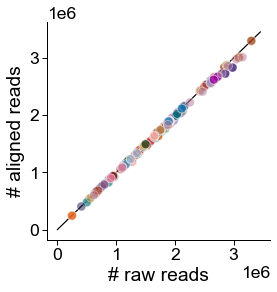

In [27]:
plt.figure(figsize=(4,4))
ax = sns.scatterplot(df, x='fastq_read_count', y='aligned_read_count',
                     hue='sample', palette=c_dict, alpha=0.5,
                     s=80)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
_ = ax.plot([0,xmax], [0,xmax], color='k', zorder=0)
ax.get_legend().remove()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
xlabel = '# raw reads'
ylabel = '# aligned reads'
_ = ax.set(xlabel=xlabel, ylabel=ylabel)

fname = 'figures/raw_vs_aligned_reads.pdf'
plt.savefig(fname, dpi=700, bbox_inches='tight')

In [22]:
primary_median = pd.merge(bam_reads[[('primary', 'median')]], fastq_reads[['median']], left_index=True, right_index=True)
primary_median.columns = ['primary_read_median', 'fastq_read_median']
primary_median.reset_index(inplace=True)
df = primary_median.copy(deep=True)
df['ENCODE_experiment_id'] = df['index'].str.split('_', expand=True)[0]


# add sample information
meta = pd.read_csv(lib_meta, sep='\t')
meta = meta[['ENCODE_experiment_id', 'sample']]
df = df.merge(meta, on='ENCODE_experiment_id')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  """Entry point for launching an IPython kernel.


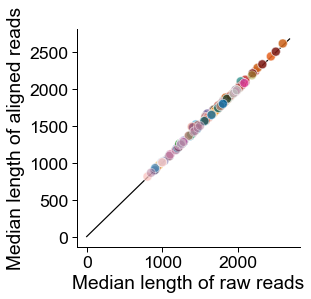

In [24]:
plt.figure(figsize=(4,4))
ax = sns.scatterplot(df, x='fastq_read_median', y='primary_read_median',
                     hue='sample', palette=c_dict, alpha=0.5, s=80)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
_ = ax.plot([0,xmax], [0,xmax], color='k', zorder=0)
ax.get_legend().remove()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
xlabel = 'Median length of raw reads'
ylabel = 'Median length of aligned reads'
_ = ax.set(xlabel=xlabel, ylabel=ylabel)

fname = 'figures/raw_vs_aligned_read_median_lengths.pdf'
plt.savefig(fname, dpi=700, bbox_inches='tight')

## GO on undetected genes

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for protein_coding genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:2026: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:2025: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # genes detected: 599976
# genes >= 1 tpm: 292060
Applying gene type and novelty subset
Number of genes reported: 18727
61544
19988
1261


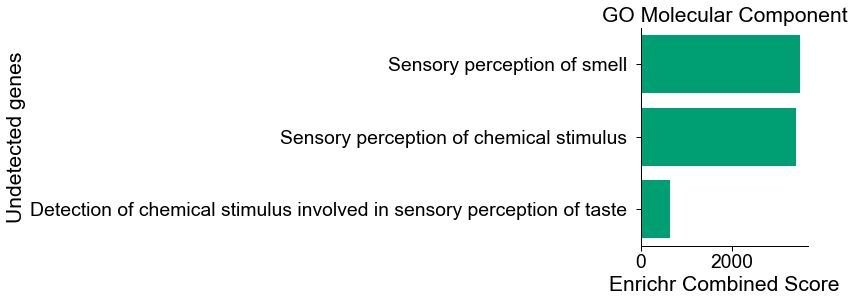

In [7]:
human_undet_gene_go(ab,
                    go_gene_subset,
                    min_tpm,
                    'figures/undet_pc_go.pdf')

## Mouse LR-RNA-seq read lengths

<Figure size 216x216 with 0 Axes>

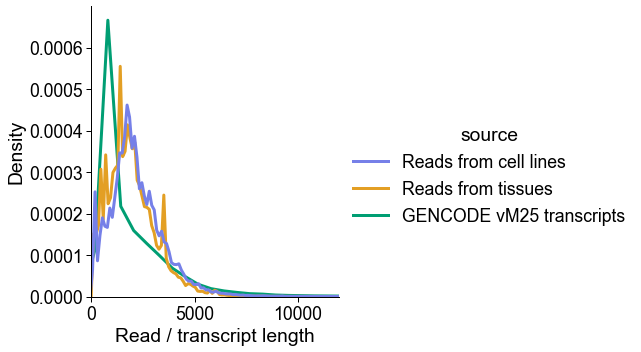

In [6]:
plot_mouse_cell_line_tissue_read_len_v_ref(mouse_read_annot,
                                           mouse_meta,
                                           gene_subset,
                                           mouse_t_metadata,
                                           12000,
                                           'figures/mouse_tissue_cell_line_ref_read_len.pdf')

<Figure size 216x216 with 0 Axes>

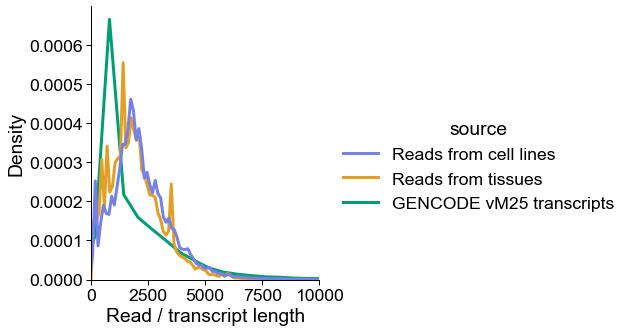

In [6]:
plot_mouse_cell_line_tissue_read_len_v_ref(mouse_read_annot,
                                           mouse_meta,
                                           gene_subset,
                                           mouse_t_metadata,
                                           10000,
                                           'figures/mouse_tissue_cell_line_ref_read_len.pdf')

## Mouse transcript-level brain, cell line, tissue UMAP


Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:2026: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:2025: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 149463
# isos >= 1 tpm: 138642
Applying gene type and novelty subset
Number of isos reported: 135450
Read in graph from ../../mouse/lr_bulk/swan/swan.p


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
Trying to set attribute `.obs` of view, copying.


['cell_line', 'tissue', 'brain']
{'cell_line': '#7680e8', 'tissue': '#e39f24', 'brain': '#b0799a'}
['brain', 'cell_line', 'tissue']
['brain', 'tissue', 'cell_line']
Categories (3, object): ['brain', 'cell_line', 'tissue']


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tissue' as categorical
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'age' as categorical
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version

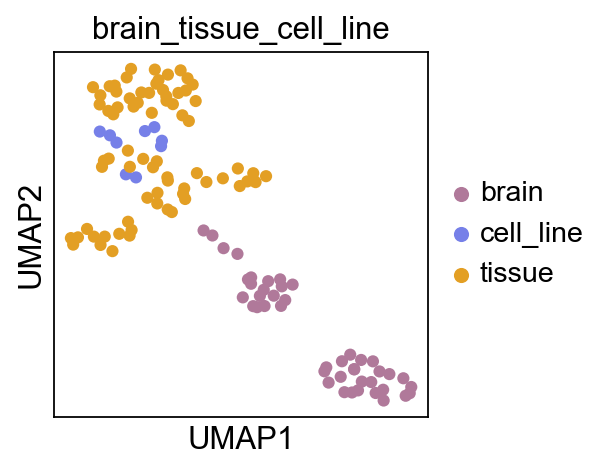

In [28]:
plot_mouse_brain_tissue_cell_line_umap(mouse_swan_file,
                                 mouse_filt_ab,
                                 min_tpm, 
                                 gene_subset,
                                 'figures/mouse_transcript_umap_brain_tissue_cell_line.pdf')


## Mouse detection by biotype

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:2026: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:2025: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Applying gene type and novelty subset
Number of genes reported: 29965
Detected 29965 / 45353 (66.1%) annotated polyA genes
protein_coding
84.8757948671028

lncRNA
59.87548950697861

pseudogene
18.37458441078685



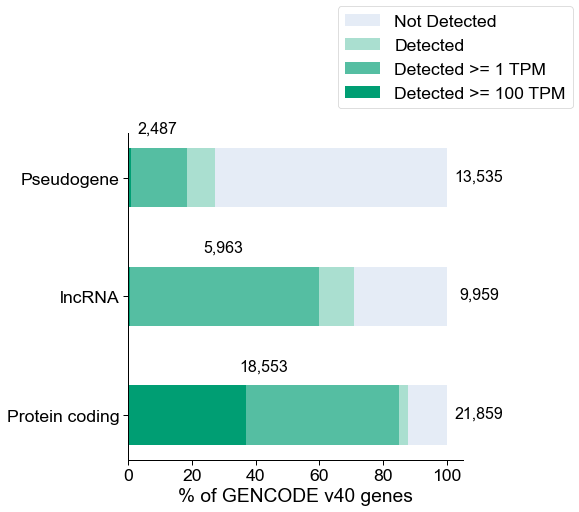

In [3]:
df = pd.read_csv(mouse_ab, sep='\t')
plot_gene_det_by_biotype_tpm(df,
                             how='gene',
                             ver=mouse_ver,
                             species='mouse')


## Mouse gene detection by sample

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # genes detected: 252602
# genes >= 1 tpm: 177043
Applying gene type and novelty subset
Number of genes reported: 27003
Found 37 total samples


biosample,adrenal gland,adrenal_10d,adrenal_14d,adrenal_18-20mo,adrenal_25d,adrenal_2mo,adrenal_36d,adrenal_4d,c2c12_myoblast,c2c12_myotube,...,heart_18-20mo,heart_2mo,hippocampus_14d,hippocampus_18-20mo,hippocampus_2mo,hippocampus_5x_f,hippocampus_5x_m,hippocampus_wt_f,hippocampus_wt_m,n_samples
ENSMUSG00000000001,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,37
ENSMUSG00000000028,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,37
ENSMUSG00000000031,True,True,True,True,True,True,True,True,True,True,...,True,True,False,True,False,False,False,False,False,23
ENSMUSG00000000037,True,True,False,True,True,True,False,True,False,False,...,False,True,True,False,False,False,False,False,False,17
ENSMUSG00000000049,False,True,True,False,True,True,True,True,True,False,...,False,False,True,True,True,True,False,True,True,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000118382,False,True,False,False,True,False,False,True,False,False,...,False,False,True,False,True,False,False,False,False,8
ENSMUSG00000118383,True,True,True,True,True,True,True,True,True,True,...,True,True,True,False,True,True,True,True,True,31
ENSMUSG00000118385,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,True,False,False,False,5
ENSMUSG00000118386,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1


<Figure size 432x288 with 0 Axes>

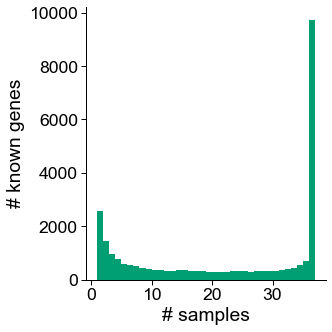

In [4]:
df = pd.read_csv(mouse_ab, sep='\t')
_ = plot_biosamp_det(df,
                 how='gene',
                 min_tpm=min_tpm,
                 gene_subset=gene_subset,
                 sample=None,
                 groupby=obs_col,
                 species='mouse',
                 opref='figures/mouse')
